# FEATURES

In [22]:
from datasets import get_dataset_split_names
from datasets import load_dataset
from datasets import dataset_dict
from datasets import arrow_dataset
import string

dataset = load_dataset("imdb")

/home/amine/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imdb (/home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 921.29it/s]


In [78]:
document = dataset["test"]["label"]
document

0

1- Preprocess function

In [24]:
def preprocess(data : dict) -> dict:
    '''Takes a document from a dataset, lowers the letters and
    replace all punctuations by spaces'''
    text = data["text"]
    for character in string.punctuation:
        if character != "-" and character != "!":
          text = text.replace(character, ' ')
    data["text"] = text.lower()
    return data

In [25]:
updated_dataset= dataset.map(preprocess)

Loading cached processed dataset at /home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a1ff6ac6f3dae5b2.arrow
Loading cached processed dataset at /home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-3ff24866f561b56d.arrow
Loading cached processed dataset at /home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c8e6bf051898815c.arrow


2- Naive Bayes classifier from scratch

In [125]:
import math
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def build_vocabulary_string(Vocabulary : dict[int], text : string, text_category : int, Categories : set[int]):
    '''Updates the Vocabulary by adding the words contained in the text'''
    
    word_count = 0
    base_vector = [0,0,0,0,0,0,0]
    feature_vector = np.array(base_vector)
    Analyser = SentimentIntensityAnalyzer()
    #test_dict = Analyser.polarity_scores(text)
    
    for word in text.split():
        if not (word in Vocabulary) :
            
            Vocabulary[word] = {}
        
            for category in Categories:
                
                Vocabulary[word][category] = 0 
        word_count += 1
        if (word == "no") :
            feature_vector[0] = 1
        if (word == "i" or word == "you") :
            feature_vector[1] +=  1
        if (word == "!") :
            feature_vector[2] = 1
        
        test_dict = Analyser.polarity_scores(word)
        if (test_dict["compound"] >= 0.05):
            feature_vector[4] += 1
        elif (test_dict["compound"] <= -0.05):
            feature_vector[5] += 1
        else : #BONUS FEATURE, number of neutral lexicon
            feature_vector[6] += 1
        Vocabulary[word][text_category] += 1
    feature_vector[3] = math.log(word_count)

    return Vocabulary, feature_vector

def build_vocabulary(dataset : dataset_dict.DatasetDict, Categories : set[int]) -> dict[int]:
    '''Construct a vocabulary from the documents contained in dataset'''
    Vocabulary = {}
    list_vector = []
    list_label = []
    count = 0
    for document in dataset:
        Vocabulary, feature_vector = build_vocabulary_string(Vocabulary, document["text"], document["label"], Categories)
        list_vector.append(feature_vector)
        list_label.append(document["label"])
       
    features_vector = np.array(list_vector)

    return Vocabulary, features_vector, list_label

In [127]:
categories = {0,1}
voc, feat, list_label = build_vocabulary(updated_dataset["train"],categories)

In [128]:
print(feat.shape)
print(len(list_label))

(25000, 7)
25000


# II REGRESSION LINEAIRE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn

In [129]:
# Forcing the random seed for reproductibility
np.random.seed(seed=42)
# Generating distributions
#first_distribution = np.random.normal(-2.0, 1.0, size=(10000, 2))
#second_distribution = np.random.normal(2.0, 1.0, size=(10000, 2))
all_points = feat
# Labels
labels = list_label


In [130]:
all_points.shape, len(labels)

((25000, 7), 25000)

In [144]:
df = pd.DataFrame()
df["no"] = all_points[:, 0]
df["pronouns"] = all_points[:, 1]
df["!"] = all_points[:, 2]
df["Log(word_count)"] = all_points[:, 3]
df["positive"] = all_points[:, 4]
df["negative"] = all_points[:, 5]
df["neutral"] = all_points[:, 6]


df["label"] = labels
df


,no,pronouns,!,Log(word_count),positive,negative,neutral,label
0,1.0,7.0,0.0,5.0,7.0,7.0,280.0,0.0
1,1.0,3.0,0.0,5.0,6.0,5.0,212.0,0.0
2,1.0,0.0,0.0,4.0,5.0,3.0,89.0,0.0
3,0.0,3.0,0.0,4.0,6.0,6.0,113.0,0.0
4,0.0,10.0,0.0,5.0,5.0,12.0,309.0,0.0
...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,4.0,7.0,4.0,97.0,1.0
24996,1.0,8.0,0.0,5.0,9.0,7.0,179.0,1.0
24997,0.0,3.0,0.0,4.0,12.0,3.0,126.0,1.0
24998,1.0,6.0,1.0,6.0,28.0,16.0,668.0,1.0


In [136]:

all_points = torch.tensor(all_points, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)

/tmp/ipykernel_61369/1062686651.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_points = torch.tensor(all_points, dtype=torch.float32)
/tmp/ipykernel_61369/1062686651.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)


In [137]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

In [140]:
model = LogisticRegression(7, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)



In [141]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)


tensor(48.8572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(33.5876, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(49.9292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(48.5530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(47.1754, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(49.9600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(49.8464, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(48.9657, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(49.4335, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(49.9029, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 2.59 s, sys: 7.92 ms, total: 2.6 s
Wall time: 651 ms


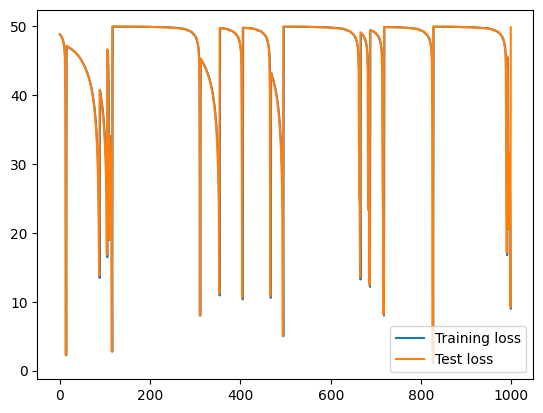

In [142]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()


In [143]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.5 0.5 0.5


In [ ]:
# Predicting new samples
model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32))

In [ ]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]


(tensor([[0.4758, 0.4785]]), tensor([0.0004]))

In [ ]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)


In [ ]:
model = LinearRegression(2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [ ]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)


tensor(1.2567, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2355, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1807, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1698, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1664, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1662, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 346 ms


In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()


In [ ]:
# Note that we need to use a sigmoid on the output now.
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)


0.99734375 0.9975 0.99775


In [ ]:
# Predicting new samples, we need to use a sigmoid on top of the output.
torch.sigmoid(model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32)))

tensor([[0.1587],
        [0.8417]], grad_fn=<SigmoidBackward0>)